[Implementation of NICE (Non-Linear Independent Components Estimation)](https://arxiv.org/pdf/1410.8516.pdf)

In [4]:
%load_ext autoreload
%autoreload 2

import os

import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Environment Path Constants you can change
DATASET_PATH = './datasets/'
CHECKPOINT_PATH ='./checkpoints/NICE/'
OUTPUT_PATH = './outputs/NICE/'
CHECKPOINT_FILE = '' #./trained_models/NICE/NICE-MNIST.pt' # If you want to load a checkpoint.
PREPROCESS_PATH = './preprocess/'

# Data Loading Constants (Dependent on your hardware)
DATASET = ['CIFAR10', 'MNIST', 'SVHN'][2]
BATCH_SIZE = 200
NUM_WORKERS = 10
PIN_MEMORY = True

# Training Constants
BATCH_PRINT = 50 # Every 50 batches print training progress.
EPOCH_CHECKPOINT = 10 # Every 10 epochs, save a checkpoint.
NUM_EPOCHS = 200
IS_TRAINING= True # Start training a model, unless you want to load a checkpoint instead.

# Set device to gpu by default if available.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# For some reproducibility and determinism (Not gauranteed)
torch.manual_seed(0)
g = torch.Generator()
g.manual_seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


print(f'Device: {device}')
print(f'CPU Count: {os.cpu_count()}')
print(f'Number of DataLoading Workers: {NUM_WORKERS}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'Dataset: {DATASET}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cuda:0
CPU Count: 20
Number of DataLoading Workers: 10
Batch Size: 200
Dataset: SVHN


### Dequantization
Using the same dequantization method from [RNADE: The real-valued neural autoregressive density-estimator](https://arxiv.org/pdf/1306.0186.pdf), section 4.2 as referenced by NICE.

Without dequantization maximizing the likelihood of our parameters relative to discrete data will result in an arbitrarily high value since the model will "cheat" as the paper describes. With discrete points the distribution would be "spiky" in the continuous space where the width of each of these points approaches 0. So, you can imagine that when we try to maximize the likelihood (in continuous space) the model will just give these points an arbitrary high value in $log(p(x;\theta))$ where $p(x;\theta)$ will have very low probability due to infinitesimal width (discrete) resulting in $log(p(x;\theta)) \rightarrow \infty$ while maintaining the constraint that $\int p(x;\theta) = 1$, hence "cheating".

In [5]:
class Dequantize(nn.Module):
    def __init__(self, device='cpu'):
        super(Dequantize, self).__init__()
        lo = torch.tensor([0.], device=device)
        hi = torch.tensor([1.], device=device)
        self.prior = torch.distributions.Uniform(lo,hi)
        
    def forward(self, x):
        return (x*255 + self.prior.sample(x.shape).squeeze()).divide(256.)

### Data Loading
Only using CIFAR-10 and MNIST dataset for this notebook. However, the paper also uses SVHN. Just flatten and dequantize the data. This also contains some other dataset specific functionalities like preprocessing

In [6]:
# Select Dataset
from torch.utils.data import Dataset
from torchvision.datasets import MNIST, CIFAR10, SVHN
import torchvision.transforms as transforms
from torchvision.utils import make_grid

def show(x, title=''):
    """ Display a grid from a batched pytorch tensor.
    """
    plt.figure(frameon=False)
    img = make_grid(x)
    npimg = img.numpy()
    plt.title(title)
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def select_dataset(dataset):
    # Any Dataset pre-processing
    if dataset != 'MNIST':
        mean = torch.tensor(np.load(f'{PREPROCESS_PATH}{dataset}.mean.npy'), dtype=torch.float32, device=device)
        zca = torch.tensor(np.load(f'{PREPROCESS_PATH}{dataset}.zca.npy'), dtype=torch.float32, device=device)
        zca_inv = zca.inverse()
        zca_min = torch.tensor(np.load(f'{PREPROCESS_PATH}{dataset}.zca_min.npy'), dtype=torch.float32, device=device)
        zca_max = torch.tensor(np.load(f'{PREPROCESS_PATH}{dataset}.zca_max.npy'), dtype=torch.float32, device=device)

        preprocess = transforms.Compose([
            transforms.Lambda(lambda x: x - mean), # 0-Mean center
            transforms.Lambda(lambda x: x@zca), # ZCA Whiten
            transforms.Lambda(lambda x: (x - zca_min) / (zca_max - zca_min)) # Rescale            
        ])

        # Invert the pre-processing
        deprocess = transforms.Compose([
            transforms.Lambda(lambda x: (x  * (zca_max - zca_min)) + zca_min),
            transforms.Lambda(lambda x: x@zca_inv),
            transforms.Lambda(lambda x: x + mean)
        ])
    else:
        preprocess = lambda x: x
        deprocess = lambda x: x

    # Setup Dataloaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.flatten()),
    ])
    
    if dataset == 'CIFAR10':
        train_data = CIFAR10(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = CIFAR10(DATASET_PATH, train=False, download=True, transform=transform)
        show_grid = lambda x, title='': show(x.reshape(-1,3,32,32),title)
    elif dataset == 'MNIST':
        train_data = MNIST(DATASET_PATH, train=True, download=True, transform=transform)
        test_data = MNIST(DATASET_PATH, train=False, download=True, transform=transform)
        show_grid = lambda x, title='': show(x.reshape(-1,1,28,28),title)
    elif dataset == 'SVHN':
        train_data = SVHN(DATASET_PATH, split='train', download=True, transform=transform)
        test_data = SVHN(DATASET_PATH, split='test', download=True, transform=transform)
        show_grid = lambda x, title='': show(x.reshape(-1,3,32,32),title)        
    else:
        assert False, f'{dataset} does not exist.'
        
    return train_data, test_data, show_grid, preprocess, deprocess

train_data, test_data, show_grid, preprocess, deprocess = select_dataset(DATASET)

Using downloaded and verified file: ./datasets/train_32x32.mat
Using downloaded and verified file: ./datasets/test_32x32.mat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


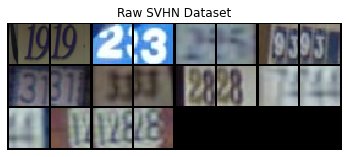

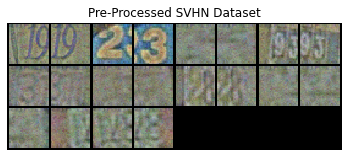

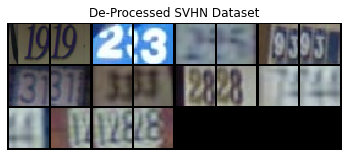

In [7]:
# Setup DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=PIN_MEMORY, generator=g)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, pin_memory=PIN_MEMORY, generator=g)
x = next(iter(train_loader))[0][:20]
show_grid(x, f'Raw {DATASET} Dataset')

x_pre = preprocess(x.to(device)).cpu()
show_grid(x_pre, f'Pre-Processed {DATASET} Dataset')
show_grid(deprocess(x_pre.to(device)).cpu(), f'De-Processed {DATASET} Dataset')

### Maintaining Invertibility
Since our model requires us to calculate the determinant of our jacobian (from Change Of Variables) it is absolutely vital that we seek to maintain this constraint while remaining computationally efficient. See: [What is a Jacobian?](https://www.youtube.com/watch?v=wCZ1VEmVjVo) and [Interpreting Determinant Jacobian](https://www.youtube.com/watch?v=p46QWyHQE6M)

One way to do this is use a simple coupling law on only half of the input. E.g: If we are using the MNIST dataset, then $x^{(i)}_{I_{1}} = [x^{(i)}_{0},x^{(i)}_{2},x^{(i)}_{4},...]$ and $x^{(i)}_{I_{2}} = [x^{(i)}_{1},x^{(i)}_{3},x^{(i)}_{5},...]$ If we do it in this way our jacobian becomes a lower triangular matrix. This would imply that our determinant would simply be the product of the diagonal of this matrix (Review linear algebra basics if you don't know why). The other half will simply be the identity function.

$f(x_{I_{1}}, x_{I_{2}}) = \begin{bmatrix} x_{I_{1}}\newline g(x_{I_{1}}, x_{I_{2}})\end{bmatrix}$

$\triangledown_{x} f = \begin{bmatrix} I & 0 \newline \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{1}}} & \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}}\end{bmatrix}$

$|\triangledown_{x} f| = I \times \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}}$

### Additive Coupling Layer
**Additive Coupling Law:** $g(a;b) = a + b$, where $g:\mathbb{R}^{D-d}\times m(\mathbb{R}^{d}) \rightarrow \mathbb{R}^{D-d}$

We'll use this additive law for each MLP layer where $x_{I_{1}}$ and $x_{I_{2}}$ is the input split in two. 

**Coupling Layer:** 

$z^{(i)}_{I_{1}} = x^{(i)}_{I_{1}}$

$z^{(i)}_{I_{2}} = g(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) = x^{(i)}_{I_{2}} + m(x^{(i)}_{I_{1}})$, where m is a deep neural network (MLP).

**Inverted Coupling Layer:** 

$x^{(i)}_{I_{1}} = z^{(i)}_{I_{1}}$

$x^{(i)}_{I_{2}} = g^{-1}(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) = g(x^{(i)}_{I_{1}}, x^{(i)}_{I_{2}}) - m(x^{(i)}_{I_{1}})$

**Jacobian Determinant of Coupling Layer:**

$|\triangledown_{x} f| = I \times \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = \dfrac{\partial g(x_{I_{1}}, x_{I_{2}})}{\partial x_{I_{2}}} = 1$

When using the additive coupling law to transform half of our input, its partial derivative becomes 1. This would imply that our model is "volume preserving" In the sense that with each transformation, the change in volume from $x \rightarrow z$ remains the same.

**Note:**
Stacking these coupling layers in succession requires us to alternate the output of each layer, otherwise only half of the input will actually be processed through all the layers. Therefore, it's important to do this equally on each half. So expect an even number of coupling layers in the model.

In [8]:
# Define Model
import torch.nn.functional as F

def add_coupling(z, m, flip=False, inverse=False):
    n = z.shape[1]
    z = z.reshape(-1, n//2, 2) # Reshaping the tensor in this way results in odd and even indexed inputs in the last dimension.
    
    # Alternate the input
    if flip:
        z2, z1 = z[:,:,0], z[:,:,1]
    else:
        z1, z2 = z[:,:,0], z[:,:,1]
        
    # Invert the coupling law
    if not inverse:
        z2 = z2 + m(z1)
    else:
        z2 = z2 - m(z1)
    
    # Bring it back to its original shape
    if flip: 
        z = torch.stack((z2.unsqueeze(-1),z1.unsqueeze(-1)), dim=2).reshape(-1,n)
    else:
        z = torch.stack((z1.unsqueeze(-1),z2.unsqueeze(-1)), dim=2).reshape(-1,n)
        
    return z

class MLP(torch.nn.Module):
    """ NOTE: Paper uses ReLU with Linear Output Units
    """
    def __init__(self, in_dim, out_dim, hidden_dim, num_layers):
        super(MLP, self).__init__()
        model = []
        
        for l in range(num_layers):
            if l == 0:
                model.append(nn.Linear(in_dim, hidden_dim))
                model.append(nn.ReLU())
            elif l == num_layers-1:
                model.append(nn.Linear(hidden_dim, out_dim))
            else:
                model.append(nn.Linear(hidden_dim, hidden_dim))
                model.append(nn.ReLU())
                
        self.mlp = nn.Sequential(*model)
        
    def forward(self, x):
        return self.mlp(x)

In [9]:
# Test to make sure this is working correctly.
z = torch.arange(784, device=device, dtype=torch.float).reshape(1,-1)
m = MLP(392,392,1000,6).to(device)

z_new = add_coupling(z, m, flip=False)
z_new = add_coupling(z_new, m, flip=True)
z_new = add_coupling(z_new, m, flip=False)
z_new = add_coupling(z_new, m, flip=True)
z_recon = add_coupling(z_new, m, flip=True, inverse=True)
z_recon = add_coupling(z_recon, m, flip=False, inverse=True)
z_recon = add_coupling(z_recon, m, flip=True, inverse=True)
z_recon = add_coupling(z_recon, m, flip=False, inverse=True)

print('MSE', ((z - z_recon)**2).mean().cpu().item())

MSE 5.773667134667537e-12


### Scaling
As stated before, since our Jacobian Detetmminant is 1, it is volume preserving. We scale each dimension across the diagonal of the Jacobian by some factor in order to allow for more model variation.

**Note:** If some arbitrary scale approaches $-\infty$ or $\infty$, the dimensionality of this model will approach 1.

In [10]:
# For some reason this has to be a class. I don't know why pytorch requires this to be a class in order for
# the parameter to update. If you just add the parameter to the NICE model, it does not train correcty.

class Scaling(nn.Module):
    def __init__(self, dim):
        super(Scaling, self).__init__()
        self.scale = nn.Parameter(
            torch.zeros((1, dim)), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if reverse:
            x = x * torch.exp(-self.scale)
        else:
            x = x * torch.exp(self.scale)
        return x, log_det_J

### Model Definition (Section 5.1)

$h_{I_{1}}^{(1)} = x_{I_{1}}$

$h_{I_{2}}^{(1)} = x_{I_{2}} + m^{(1)}(x_{I_{1}})$

$h_{I_{2}}^{(2)} = h_{I_{2}}^{(1)}$

$h_{I_{2}}^{(2)} = h_{I_{1}}^{(1)} + m^{(2)}(x_{I_{2}})$

$h_{I_{2}}^{(3)} = h_{I_{2}}^{(2)}$

$h_{I_{2}}^{(3)} = h_{I_{2}}^{(2)} + m^{(3)}(x_{I_{1}})$

$h_{I_{2}}^{(4)} = h_{I_{2}}^{(3)}$

$h_{I_{1}}^{(4)} = h_{I_{1}}^{(3)} + m^{(4)}(x_{I_{2}})$

$h= exp(s)\odot h^{(4)}$

where $m$ is the coupling function and h's are the input/outputs.

In [11]:
# Define the main model
def logistic(sample_shape, prior):
    z = prior.sample(sample_shape).squeeze()
    return torch.log(z) - torch.log(1. - z)

def log_logistic(z):
    return -(F.softplus(z) + F.softplus(-z))
    #return -torch.log(1 + torch.exp(z)) - torch.log(1 + torch.exp(-z))

class NICE(torch.nn.Module):
    def __init__(self, num_coupling=4, num_dim=784, num_hidden_units=1000, num_hidden_layers=4, prior_fn=log_logistic, coupling_fn=add_coupling, device='cpu'):
        super(NICE, self).__init__()
        assert num_coupling % 2 == 0, 'We want an even number of swaps.'
        
        self.coupling_fn = add_coupling
        self.prior_fn = log_logistic
        self.mlps = nn.ModuleList([ MLP(num_dim // 2, num_dim // 2, num_hidden_units, num_hidden_layers+2).to(device) for i in range(num_coupling)])
        #self.scaling = nn.Parameter(torch.rand(1, num_dim), requires_grad=True).to(device) # Apparently this has to be not equal to 0, it can't be rand either, it has to be a module.
        self.scaling = Scaling(num_dim)
        self.dequantize = Dequantize(device)
        
    def forward(self, x):
        # Transform to P_x -> P_z
        z = self.dequantize(x)
        for i, m in enumerate(self.mlps):
            z = self.coupling_fn(z, m, flip=(i%2 != 0), inverse=False)
        
        #z = torch.exp(self.scaling) * z
        #logdet = self.scaling
        z, logdet = self.scaling(z)
        logprior = log_logistic(z)
        
        return logprior, logdet
    
    def sample(self, sample_shape=(64,784)):
        return self.inverse(logistic(sample_shape))

    def inverse(self, z):
        x = z
        x, _ = self.scaling(x, reverse=True)

        for i, m in reversed(list(enumerate(self.mlps))):
            x = self.coupling_fn(x, m, flip=(i%2 != 0 ), inverse=True)
        return x

### Log Likelihood

Recall the change of variable:

$p_{X}(x) = p_{H}(f(x))|det\dfrac{\partial f(x)}{\partial x}|$, where $p_{H}$ is our prior (Logistic Distribution), and $p_{X}$ is the distribution of our dataset.

In NICE, we assume that each component, $h_{d}$ is independent and so $p_{H}$ factorizes into $p_{H}(h) = \prod_{d}p_{H_{d}}(h_{d})$.

And so now we simply maximize the log likelihood using the change of variable likeso:

$log(p_{X}(x)) = \sum_{d=1}^{D}log(p_{H_{d}}(f_{d}(x))) + log(|det(\dfrac{\partial f(x)}{\partial x})|)$

This is now:

$log(p_{X}(x)) = \sum_{d=1}^{D}log(p_{H_{d}}(f_{d}(x))) + log(|S_{ii}|)$, where $S_{ii}$ are the learned scaling parameters used in conjunction with the unit determinant jocabian of the additive coupling layers.



In [12]:
# Loss Function.
def log_likelihood(logprior, logdet):
    return logprior.sum(dim=1) + logdet

### Hyper Parameters
![Section 5.1](./images/NICE_hyperparameters.JPG)

Section 5.1 in the paper.

**Note:** Not using ZCA in this notebook. If you want it, add it to to DataLoader preprocessing.

In [13]:
from torch import optim

# Model Configuration
if DATASET == 'MNIST':
    hyper_parameters = {
        'num_dim': 784,
        'num_hidden_units':1000,
        'device': device
    }
    
    model = NICE(**hyper_parameters).to(device)
    sample_shape = (64,784)
    img_shape = (1,28,28)
elif DATASET == 'CIFAR10':
    hyper_parameters = {
        'num_dim': 3072,
        'num_hidden_units': 2000,
        'device': device    
    }
    
    model = NICE(**hyper_parameters).to(device)
    sample_shape = (64,3072)
    img_shape = (3,32,32)
elif DATASET == 'SVHN':
    hyper_parameters = {
        'num_dim': 3072,
        'num_hidden_units': 2000,
        'device': device    
    }
    
    model = NICE(**hyper_parameters).to(device)
    sample_shape = (64,3072)
    img_shape = (3,32,32)
    
optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-4)

### Load Checkpoint
If available...

In [14]:
if CHECKPOINT_FILE != '':
    ckpt = torch.load(CHECKPOINT_FILE)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    epoch = ckpt['epoch']

### Training

Epochs: [0/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: 4449.962890625
Running Batch Time: 0.35596156120300293
Epochs: [0/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: 5534.547076056985
Running Batch Time: 0.025360911500220205
Epochs: [0/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: 5022.626126431002
Running Batch Time: 0.021895665933590124
Epochs: [0/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: 4733.5988753363
Running Batch Time: 0.020722382905467455
Epochs: [0/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: 4582.718177909282
Running Batch Time: 0.020126929923669615
Epochs: [0/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: 4454.931873093563
Running Batch Time: 0.019772206644612954
Epochs: [0/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: 4347.710546550561
Running Batch Time: 0.0195508803244049
Epochs: [0/200]	Batches: [351/367]	Samples: [70200/73257]	Running Loss: 4254.2828038750895
Runni

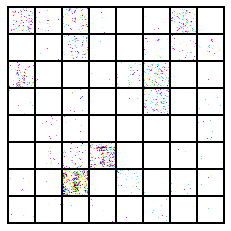

Training Likelihood: -4226.2973952124485	Test Likelihood: -3591.798583984375
Epochs: [1/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: 3591.95751953125
Running Batch Time: 2.37931752204895
Epochs: [1/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: 3530.0572150735293
Running Batch Time: 0.0644687531041164
Epochs: [1/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: 3467.527218053837
Running Batch Time: 0.041549241188729165
Epochs: [1/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: 3404.152919339818
Running Batch Time: 0.03380265614844316
Epochs: [1/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: 3340.102783203125
Running Batch Time: 0.029928412603501656
Epochs: [1/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: 3275.3305994770917
Running Batch Time: 0.02755289343723738
Epochs: [1/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: 3209.9973055310425
Running Batch Time: 0.025962155522698184
Epochs: [1/200]	B

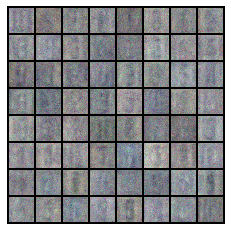

Training Likelihood: 4233.707136356863	Test Likelihood: 4385.57373046875
Epochs: [11/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4301.6181640625
Running Batch Time: 2.3690593242645264
Epochs: [11/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4363.531843596814
Running Batch Time: 0.06436955227571375
Epochs: [11/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4371.832911123143
Running Batch Time: 0.04154509364968479
Epochs: [11/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4388.713833234168
Running Batch Time: 0.03385776873455932
Epochs: [11/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4391.441089231576
Running Batch Time: 0.029997654815218343
Epochs: [11/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4404.784927672124
Running Batch Time: 0.02766843146061992
Epochs: [11/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4413.975857655471
Running Batch Time: 0.026111308126354534
Epochs: [

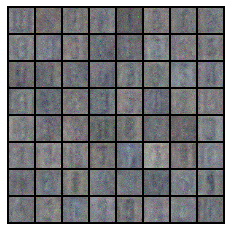

Training Likelihood: 4699.6232251575275	Test Likelihood: 4807.91650390625
Epochs: [21/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4636.189453125
Running Batch Time: 2.3782565593719482
Epochs: [21/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4707.842036228554
Running Batch Time: 0.06553548925063189
Epochs: [21/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4709.913521039604
Running Batch Time: 0.04236179767268719
Epochs: [21/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4717.4509164165975
Running Batch Time: 0.03448284382851708
Epochs: [21/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4708.028645833333
Running Batch Time: 0.03053458057232757
Epochs: [21/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4712.468870611305
Running Batch Time: 0.028140960936527327
Epochs: [21/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4713.181097189057
Running Batch Time: 0.026519634398907126
Epochs: 

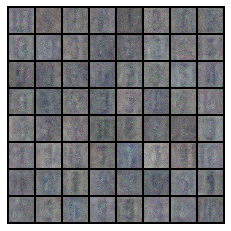

Training Likelihood: 4797.558821259792	Test Likelihood: 4905.59619140625
Epochs: [31/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4728.4951171875
Running Batch Time: 2.3578250408172607
Epochs: [31/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4804.177303538603
Running Batch Time: 0.06440343576319077
Epochs: [31/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4802.703971031869
Running Batch Time: 0.041593443049062595
Epochs: [31/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4807.780173194329
Running Batch Time: 0.0338783295738776
Epochs: [31/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4797.23973394745
Running Batch Time: 0.030029269593272043
Epochs: [31/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4801.191892585906
Running Batch Time: 0.02769230656414868
Epochs: [31/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4800.9652866097385
Running Batch Time: 0.0261465449665868
Epochs: [31

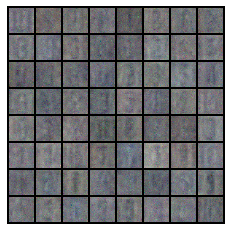

Training Likelihood: 4845.417456520351	Test Likelihood: 4943.353515625
Epochs: [41/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4770.41796875
Running Batch Time: 2.3559365272521973
Epochs: [41/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4847.131998697917
Running Batch Time: 0.06450564721051384
Epochs: [41/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4843.863943572092
Running Batch Time: 0.04171655201675868
Epochs: [41/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4847.833030448055
Running Batch Time: 0.03397263438496369
Epochs: [41/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4836.683229361008
Running Batch Time: 0.03008212853426957
Epochs: [41/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4840.095345181773
Running Batch Time: 0.02773745886358132
Epochs: [41/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4840.158607052014
Running Batch Time: 0.026180353671609365
Epochs: [41/20

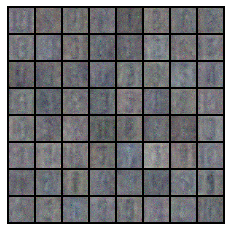

Training Likelihood: 4876.91279057391	Test Likelihood: 4971.80712890625
Epochs: [51/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4803.03369140625
Running Batch Time: 2.3705568313598633
Epochs: [51/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4879.578306908701
Running Batch Time: 0.06460257137522978
Epochs: [51/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4878.0101427134905
Running Batch Time: 0.04182447773395198
Epochs: [51/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4883.146591085472
Running Batch Time: 0.03407839907715652
Epochs: [51/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4871.44823489972
Running Batch Time: 0.03017336337720577
Epochs: [51/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4874.417225628735
Running Batch Time: 0.02779437251299976
Epochs: [51/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4874.331781431686
Running Batch Time: 0.026270023612088935
Epochs: [5

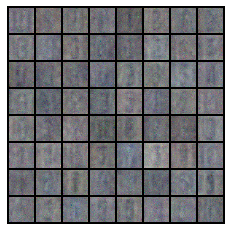

Training Likelihood: 4884.039417734588	Test Likelihood: 4964.4609375
Epochs: [61/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4799.61962890625
Running Batch Time: 2.380936622619629
Epochs: [61/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4887.520345052083
Running Batch Time: 0.06470798043643727
Epochs: [61/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4886.491268951114
Running Batch Time: 0.04172127317674089
Epochs: [61/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4891.156424617136
Running Batch Time: 0.03396746496491085
Epochs: [61/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4878.535557077892
Running Batch Time: 0.030049012075016153
Epochs: [61/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4882.409273063994
Running Batch Time: 0.02771538092320659
Epochs: [61/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4882.42428558451
Running Batch Time: 0.026142129074299456
Epochs: [61/20

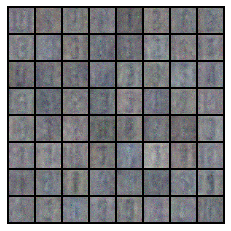

Training Likelihood: 4895.2983717749485	Test Likelihood: 4972.93212890625
Epochs: [71/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4811.7763671875
Running Batch Time: 2.3500454425811768
Epochs: [71/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4896.629815793505
Running Batch Time: 0.06422826823066263
Epochs: [71/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4893.607939163057
Running Batch Time: 0.04149462681005497
Epochs: [71/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4898.680557352028
Running Batch Time: 0.03388028429044004
Epochs: [71/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4887.395697294776
Running Batch Time: 0.030079628104594216
Epochs: [71/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4891.406187749004
Running Batch Time: 0.027791656820897563
Epochs: [71/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4892.144558827346
Running Batch Time: 0.026271945218311197
Epochs:

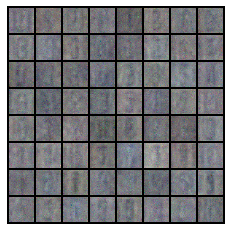

Training Likelihood: 4920.083814075272	Test Likelihood: 4992.17919921875
Epochs: [81/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4842.22314453125
Running Batch Time: 2.421830177307129
Epochs: [81/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4921.189520143995
Running Batch Time: 0.06560444364360735
Epochs: [81/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4921.463180693069
Running Batch Time: 0.042157435181117295
Epochs: [81/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4926.2240499534355
Running Batch Time: 0.03423180327510202
Epochs: [81/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4914.982710956934
Running Batch Time: 0.030269423527504082
Epochs: [81/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4918.270035093999
Running Batch Time: 0.02787278277940484
Epochs: [81/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4917.851463545992
Running Batch Time: 0.026278251825377
Epochs: [8

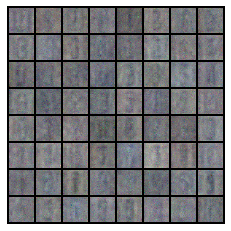

Training Likelihood: 4947.306877448059	Test Likelihood: 5027.978515625
Epochs: [91/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4875.962890625
Running Batch Time: 2.3365936279296875
Epochs: [91/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4946.694383808211
Running Batch Time: 0.06423567790611118
Epochs: [91/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4945.160678372525
Running Batch Time: 0.04157018189383025
Epochs: [91/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4949.534409276697
Running Batch Time: 0.033905616659202324
Epochs: [91/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4938.49074694885
Running Batch Time: 0.030152771603408738
Epochs: [91/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4941.836523048431
Running Batch Time: 0.027848473583084652
Epochs: [91/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4941.685918358077
Running Batch Time: 0.026240344855476456
Epochs: [91

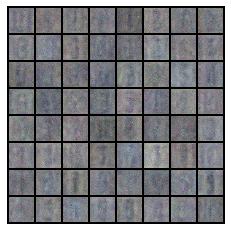

Training Likelihood: 4944.951966163573	Test Likelihood: 5016.9951171875
Epochs: [101/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4876.556640625
Running Batch Time: 2.5683281421661377
Epochs: [101/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4950.455346200981
Running Batch Time: 0.06887117554159726
Epochs: [101/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4947.738890392946
Running Batch Time: 0.043881909682018924
Epochs: [101/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4952.84477506726
Running Batch Time: 0.03546301102796138
Epochs: [101/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4941.441289645522
Running Batch Time: 0.031270279813168655
Epochs: [101/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4944.100875793701
Running Batch Time: 0.028770192210892758
Epochs: [101/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4944.8128309281565
Running Batch Time: 0.027087636168216946
Ep

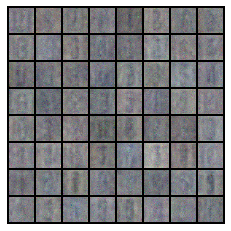

Training Likelihood: 4960.704379630024	Test Likelihood: 5015.68212890625
Epochs: [111/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4877.29931640625
Running Batch Time: 2.368178129196167
Epochs: [111/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4958.779823452819
Running Batch Time: 0.06476969812430587
Epochs: [111/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4959.224551361386
Running Batch Time: 0.04184798911066338
Epochs: [111/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4965.52378026697
Running Batch Time: 0.034139510022093915
Epochs: [111/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4954.489648923352
Running Batch Time: 0.0302417989987046
Epochs: [111/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4958.110690052291
Running Batch Time: 0.027908575962264225
Epochs: [111/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4957.870135031665
Running Batch Time: 0.026323061052746947
Epo

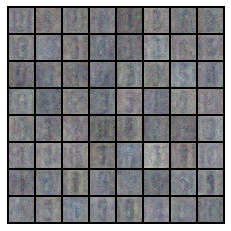

Training Likelihood: 4975.376053729564	Test Likelihood: 5031.087890625
Epochs: [121/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4893.8056640625
Running Batch Time: 2.3460662364959717
Epochs: [121/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4975.806908700981
Running Batch Time: 0.06409738578048407
Epochs: [121/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4973.654282371596
Running Batch Time: 0.04140428033205542
Epochs: [121/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4979.977167192674
Running Batch Time: 0.033719741745500374
Epochs: [121/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4969.250818660603
Running Batch Time: 0.029859755169692918
Epochs: [121/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4972.546892508092
Running Batch Time: 0.02755127105104971
Epochs: [121/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4972.079627154278
Running Batch Time: 0.02599390638231043
Epoc

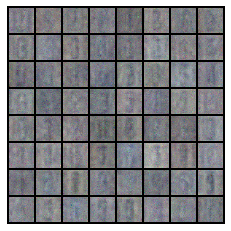

Training Likelihood: 4977.48085857672	Test Likelihood: 5031.59521484375
Epochs: [131/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4902.3203125
Running Batch Time: 2.371823787689209
Epochs: [131/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4985.389399509804
Running Batch Time: 0.06478635937559839
Epochs: [131/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4981.984413675743
Running Batch Time: 0.041916547435345036
Epochs: [131/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4985.564556601821
Running Batch Time: 0.0341739480858607
Epochs: [131/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4976.557860113495
Running Batch Time: 0.030270042704112494
Epochs: [131/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4981.7935290089645
Running Batch Time: 0.027927792879689738
Epochs: [131/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4983.1151889534885
Running Batch Time: 0.026365372033610297
Epoc

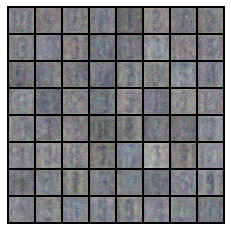

Training Likelihood: 4993.927097081489	Test Likelihood: 5045.37548828125
Epochs: [141/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4917.37158203125
Running Batch Time: 2.384014844894409
Epochs: [141/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -4992.731339996936
Running Batch Time: 0.06490058057448443
Epochs: [141/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -4991.337363668007
Running Batch Time: 0.04187949341122467
Epochs: [141/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -4996.869476924669
Running Batch Time: 0.03408398533499004
Epochs: [141/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4985.361959732587
Running Batch Time: 0.03016232732516616
Epochs: [141/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -4989.332941670817
Running Batch Time: 0.027854247872098035
Epochs: [141/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -4989.213096643999
Running Batch Time: 0.026281209483099144
Ep

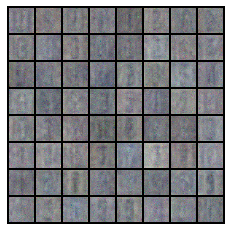

Training Likelihood: 5006.095346559946	Test Likelihood: 5031.76953125
Epochs: [151/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4916.2412109375
Running Batch Time: 2.415754795074463
Epochs: [151/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -5001.947696461397
Running Batch Time: 0.06570890838024664
Epochs: [151/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -5002.352394028465
Running Batch Time: 0.04230639722087596
Epochs: [151/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -5007.415776334851
Running Batch Time: 0.03443813481867708
Epochs: [151/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -4996.805819535137
Running Batch Time: 0.030446037131162427
Epochs: [151/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -5001.088139628984
Running Batch Time: 0.028084248660570122
Epochs: [151/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -5001.142957719061
Running Batch Time: 0.02647752698473756
Epochs

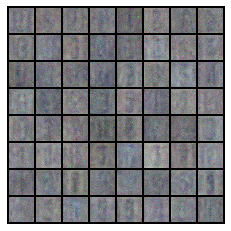

Training Likelihood: 5021.722026939288	Test Likelihood: 5081.2216796875
Epochs: [161/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4955.80078125
Running Batch Time: 2.346201181411743
Epochs: [161/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -5022.43807444853
Running Batch Time: 0.06441589897754145
Epochs: [161/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -5020.582181118502
Running Batch Time: 0.04156005028450843
Epochs: [161/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -5024.641701805671
Running Batch Time: 0.033831597953442705
Epochs: [161/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -5013.315747920554
Running Batch Time: 0.029940048853556316
Epochs: [161/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -5017.193503330428
Running Batch Time: 0.027602688724776187
Epochs: [161/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -5017.120900708575
Running Batch Time: 0.026046084407160053
Epoch

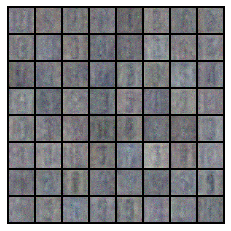

Training Likelihood: 5030.399932944482	Test Likelihood: 5067.94873046875
Epochs: [171/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4949.9931640625
Running Batch Time: 2.332451105117798
Epochs: [171/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -5032.959989659927
Running Batch Time: 0.06410286473292931
Epochs: [171/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -5032.849575533725
Running Batch Time: 0.04161620612191682
Epochs: [171/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -5037.426149886175
Running Batch Time: 0.034159715601940026
Epochs: [171/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -5027.067501846238
Running Batch Time: 0.03024570384428869
Epochs: [171/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -5030.347574545568
Running Batch Time: 0.027874766118023024
Epochs: [171/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -5029.874263522633
Running Batch Time: 0.026279042329503056
Ep

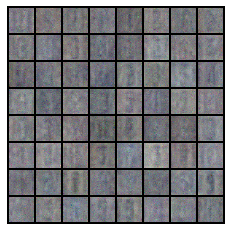

Training Likelihood: 5039.308512591536	Test Likelihood: 5084.06005859375
Epochs: [181/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4965.48486328125
Running Batch Time: 2.353747606277466
Epochs: [181/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -5039.483206954656
Running Batch Time: 0.06454203643050849
Epochs: [181/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -5039.285712213799
Running Batch Time: 0.0417070742880944
Epochs: [181/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -5042.94677734375
Running Batch Time: 0.03395115618674171
Epochs: [181/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -5031.401206856343
Running Batch Time: 0.030057889312060913
Epochs: [181/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -5034.499110977963
Running Batch Time: 0.027718959101642744
Epochs: [181/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -5034.348722033326
Running Batch Time: 0.026156597359235898
Epo

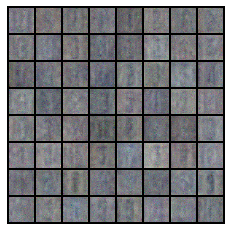

Training Likelihood: 5021.719883557561	Test Likelihood: 5065.099609375
Epochs: [191/200]	Batches: [1/367]	Samples: [200/73257]	Running Loss: -4951.1220703125
Running Batch Time: 2.372032403945923
Epochs: [191/200]	Batches: [51/367]	Samples: [10200/73257]	Running Loss: -5010.931870404412
Running Batch Time: 0.06477554639180501
Epochs: [191/200]	Batches: [101/367]	Samples: [20200/73257]	Running Loss: -5009.212165454826
Running Batch Time: 0.041834654194293636
Epochs: [191/200]	Batches: [151/367]	Samples: [30200/73257]	Running Loss: -5016.942091783941
Running Batch Time: 0.0340698365344117
Epochs: [191/200]	Batches: [201/367]	Samples: [40200/73257]	Running Loss: -5009.211338327892
Running Batch Time: 0.030238169342724244
Epochs: [191/200]	Batches: [251/367]	Samples: [50200/73257]	Running Loss: -5013.654627583416
Running Batch Time: 0.0279158577026124
Epochs: [191/200]	Batches: [301/367]	Samples: [60200/73257]	Running Loss: -5013.89822661441
Running Batch Time: 0.02637157487710845
Epochs: 

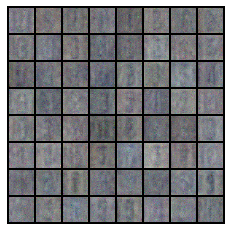

Training Likelihood: 5037.249877597071	Test Likelihood: 5079.376953125


In [15]:
from torchvision.utils import save_image
from datetime import datetime
from meters import LossMeter, HWMeter

# Generate a fixed point in logistic space to invert across training. Allows us to see progress.
lo = torch.tensor([0.], device=device)
hi = torch.tensor([1.], device=device)
prior = torch.distributions.Uniform(lo,hi)
fixed_sample = logistic(sample_shape, prior)

# Record the inverse during training for visualization purposes
inverse_records = []
batch_rate = 4
max_iters = 300
rec_iter = 0
# Local training variables
train_lls = []
test_lls = []
epoch = 0
loss_meter = LossMeter(NUM_EPOCHS, len(train_loader), BATCH_SIZE, len(train_loader.dataset))
hw_meter = HWMeter(device)
while epoch < NUM_EPOCHS and IS_TRAINING:
        
        # Train Loop
        model.train()
        for i, (x,y) in enumerate(train_loader):
            for param in model.parameters():
                param.grad = None
                
            x = preprocess(x.to(device))

            logprior, logdet = model(x)
            nll = -log_likelihood(logprior, logdet).mean()
            nll.backward()
            
            optimizer.step() 
            loss_meter.step(nll.item(), i, epoch)
            hw_meter.step(i)
            
            # Print some information
            if i % BATCH_PRINT == 0:
                loss_meter.print()
                hw_meter.print()
                
                # Record Inverse
                if rec_iter < max_iters:
                    with torch.no_grad():
                        sample = deprocess(model.inverse(fixed_sample))
                        inverse_records.append((sample.detach(), epoch, i, -loss_meter.running_loss / (i+1)))
                    rec_iter += 1
        train_ll = -loss_meter.running_loss / len(train_loader)
        
        # Test Loop
        model.eval()
        with torch.no_grad():
            test_ll = 0.
            for i, (x,y) in enumerate(test_loader):
                x = preprocess(x.to(device))
                logprior, logdet = model(x)
                ll = log_likelihood(logprior, logdet).sum()
                test_ll += ll
        test_ll /= len(test_loader.dataset)
        
        # Save Likelihoods
        train_lls.append(train_ll)
        test_lls.append(test_ll.item())

        # Store a Checkpoint
        if epoch % EPOCH_CHECKPOINT == 0 or epoch == NUM_EPOCHS-1:
            time = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
            ckptpath = f'{CHECKPOINT_PATH}NICE-{DATASET}-{time}-{epoch}.pt'
            torch.save({
                        'epoch': epoch,
                        'dataset': DATASET,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_ll': train_ll,
                        'test_ll': test_ll.item(),
                        **hyper_parameters
                        }, ckptpath)
            print(f'Saving {ckptpath}.')

            # Save a sample
            outpath = f'{OUTPUT_PATH}NICE-{DATASET}-{time}-{epoch}-{nll}.jpg'
            model.eval()
            with torch.no_grad():
                samples = deprocess(model.inverse(fixed_sample))
            print(f'Saving {outpath}')
            grid = make_grid(samples.reshape(((-1,)+img_shape)).detach().cpu().clamp(0, 1))
            show(grid)
            plt.show()
            
        epoch += 1
        loss_meter.reset()
        hw_meter.reset()
        
        print(f'Training Likelihood: {train_ll}\tTest Likelihood: {test_ll}')


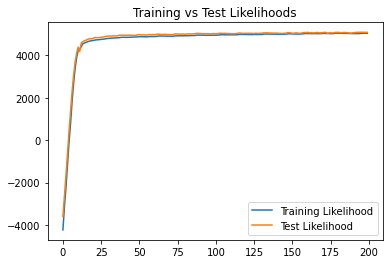

In [16]:
import imageio
import io

if IS_TRAINING:
    plt.figure()
    plt.title('Training vs Test Likelihoods')
    plt.plot(train_lls, label='Training Likelihood')
    plt.plot(test_lls, label='Test Likelihood')
    plt.legend()
    
    # Save Gif
    images = []
    for inv, epoch, batch, ll in inverse_records:
        grid = np.moveaxis(make_grid(inv.reshape(((-1,)+img_shape)).cpu()).clamp(0,1).numpy(),0,-1)
        fig = plt.figure(frameon=False)
        c,h,w = grid.shape
        fig.set_size_inches(3,3)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        plt.imshow(grid)
        
        io_buf = io.BytesIO()
        fig.savefig(io_buf, format='raw',)
        w, h = fig.canvas.get_width_height()
        io_buf.seek(0)
        img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),newshape=(h,w, -1))
        io_buf.close()
        plt.close()
        images.append(img_arr)
    imageio.mimsave(f'NICE-{DATASET}.gif', images, duration = .05)


### Samples
Some random samples in logistic space inverted to data space.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


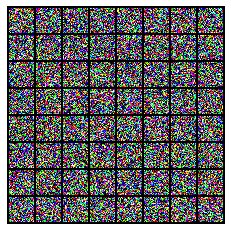

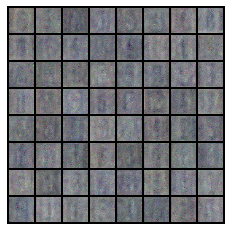

In [18]:
samples = logistic(sample_shape, prior)

grid = show_grid(samples.reshape(((-1,)+img_shape)).detach().cpu())
samples = deprocess(model.inverse(samples))
grid = show_grid(samples.reshape(((-1,)+img_shape)).detach().cpu())